# _PROJECT_: Prediction Errors Predict Belief Update

In [2]:
# Core analysis packages

from pandas import ExcelWriter
from pandas import ExcelFile
import xlsxwriter 
from statsmodels.formula.api import ols
import pingouin as pg
import researchpy

import numpy as np
import os, sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
import bff
# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

## 1 $-$ Reshape data matrix into data column

In [4]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("data_PredictionBeliefs.xlsx"), index_col=0)
df.head()

,cond,party,CHANGE,1N,2N,3N,4N,5N,6N,7N,...,5R.2,6R.2,7R.2,8R.2,9R.2,10R.2,11R.2,12R.2,Unnamed: 114,BeliefResistance
Response ID,,,,,,,,,,,,,,,,,,,,,
Over_Under,NaN,NaN,NaN,1,1,1,0,0,0,1,...,0,0,1,1,1,0,0,0,NaN,NaN
Support_Against,NaN,NaN,NaN,1,1,1,1,1,1,0,...,1,1,0,0,0,0,0,0,NaN,NaN
Dem_Rep_Ind,NaN,NaN,NaN,3,3,3,3,3,3,3,...,2,2,2,2,2,2,2,2,NaN,NaN
R_1QFNdmPJuxutFfg,1.0,1.0,NaN,-13,-3,11,-11,1,6,7,...,75,66,84,69,81,71,69,79,NaN,4.666667
R_3q9dUCiu4RWa9Ol,1.0,1.0,NaN,45,25,10,-2,10,45,-20,...,50,70,15,30,20,10,65,100,NaN,2.333333


#### $-$ Unpack data from dataframe

We want to use the row/column labels printed in the header above to extract data (typically matrices) and data labels (typically vectors). In this case, participants are rows and items are columns, which means participant-based labels are columns and item-based labels are rows.

In [7]:
# Extract rows with df.loc["target",:], only grabbing data corresponding to items
nitemlabel = 3
overunder = df.loc["Over_Under", "1N":"12R"]
supportagainst = df.loc["Support_Against", "1N":"12R"]
itemideology = df.loc["Dem_Rep_Ind", "1N":"12R"]
itemnum = np.arange(itemideology.size)
# Then remove these rows from the dataframe and continue
dftrim = df.iloc[nitemlabel:, :]

# Extract columns with df.target or df["target"] or df.loc[:,"target"]
cond = dftrim.loc[:, "cond"]
partideology = dftrim.loc[:, "party"]
resist = dftrim.loc[:, "BeliefResistance"]
partnum = np.arange(partideology.size)

# Extract data with df.loc[:,"datastart":"dataend"]
deltaB = dftrim.loc[:, "1N":"12R"]
signedPE = dftrim.loc[:, "1N.1":"12R.1"]
PE = signedPE.abs().astype(int)
Bpre = dftrim.loc[:, "1N.2":"12R.2"]
sz = deltaB.shape
print(sz)

(704, 36)


#### 1b $-$ Repack data into new dataframe in column-form
First, we expand every piece of data unpacked above to match the shape of the data. Then, we reshape all of them into columns and combine into a new dataset ready for analysis.

In [8]:
names = ["deltaB", "signedPE", "PE", "Bpre", "overunder", "supportagainst", "itemideology", "itemnum", \
         "cond", "partideology", "resist", "partnum"]
data_packed = np.broadcast_arrays(deltaB, signedPE, PE, Bpre, overunder, supportagainst, itemideology, itemnum)
cols = [np.tile(a, (sz[1],1)).T for a in [cond, partideology, resist, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
DATA = pd.DataFrame(data=data_unpacked, columns=names)

#### 1c $-$ Rational update direction

"Rational" update reflects a resigning of each belief change such that the "rational" direction is always positive. If a participant has a huge underestimated PE of evidence that refutes the belief, for example, the rational response is to decrease the belief; in data analysis terms, we multiply this belief change by $-1$:

$$\textsf{Rational }\Delta B = \textsf{sign}({Support/Against})\cdot\textsf{sign}({Over/Under})\cdot\textsf{sign}({PE})\cdot\Delta B$$

In [9]:
# We add a small positive number to prediction errors such that sign(0) = 1
RUD = np.sign(DATA["supportagainst"] - 0.5) * np.sign(DATA["overunder"] - 0.5) * np.sign(DATA["signedPE"] + 0.01)
RUD_control = np.sign(DATA["supportagainst"] - 0.5)
RUD[DATA["cond"]==2] = RUD_control[DATA["cond"]==2]
# Rational belief update
RdeltaB = DATA["deltaB"]*RUD
if "RdeltaB" in DATA:
    DATA["RdeltaB"] = RdeltaB
else:
    DATA.insert(0, "RdeltaB", RdeltaB)
# Rational update interval
RpreI = np.abs((RUD+1)*50 - DATA["Bpre"])
if "RpreI" in DATA:
    DATA["RpreI"] = RpreI
else:
    DATA.insert(5, "RpreI", RpreI)
if "RpreI" in DATA:
    DATA["RpreI"] = RpreI
else:
    DATA.insert(5, "RpreI", RpreI)

DATA.head()

,RdeltaB,deltaB,signedPE,PE,Bpre,RpreI,overunder,supportagainst,itemideology,itemnum,cond,partideology,resist,partnum
0,13.0,-13.0,-1.0,1.0,80.0,80.0,1.0,1.0,3.0,0.0,1.0,1.0,4.666667,0.0
1,-3.0,-3.0,4.0,4.0,84.0,16.0,1.0,1.0,3.0,1.0,1.0,1.0,4.666667,0.0
2,11.0,11.0,1.0,1.0,70.0,30.0,1.0,1.0,3.0,2.0,1.0,1.0,4.666667,0.0
3,-11.0,-11.0,-1.0,1.0,77.0,23.0,0.0,1.0,3.0,3.0,1.0,1.0,4.666667,0.0
4,1.0,1.0,-7.0,7.0,71.0,29.0,0.0,1.0,3.0,4.0,1.0,1.0,4.666667,0.0


## 3 $-$ Plot belief vs. PE
First, we transform the raw PEs into bins in a new column of the dataframe. Then, we can use seaborn to make simple barplots.

In [10]:
bins = [[0],[1,2,3,4,5],[6,7,8,9,10,11]]
binedges = [a[0] - 0.5 for a in bins] + [bins[-1][-1] + 0.5]
# Digitize the prediction 
binnedPE = np.digitize(DATA["PE"], binedges)-1
# Force control condition to be bin "3" (the rightmost bin)
binnedPE[DATA["cond"]==2] = 3
DATA.insert(3,"binnedPE",binnedPE)

In [11]:
makeslargePEs = np.unique(np.array(DATA.loc[DATA["binnedPE"]==2, "partnum"]))
canmakelargePEs = np.unique(np.array(DATA.loc[DATA["cond"]==1, "partnum"]))
print(np.setdiff1d(canmakelargePEs, makeslargePEs))

[]


In [12]:
DATA.head()

,RdeltaB,deltaB,signedPE,binnedPE,PE,Bpre,RpreI,overunder,supportagainst,itemideology,itemnum,cond,partideology,resist,partnum
0,13.0,-13.0,-1.0,1,1.0,80.0,80.0,1.0,1.0,3.0,0.0,1.0,1.0,4.666667,0.0
1,-3.0,-3.0,4.0,1,4.0,84.0,16.0,1.0,1.0,3.0,1.0,1.0,1.0,4.666667,0.0
2,11.0,11.0,1.0,1,1.0,70.0,30.0,1.0,1.0,3.0,2.0,1.0,1.0,4.666667,0.0
3,-11.0,-11.0,-1.0,1,1.0,77.0,23.0,0.0,1.0,3.0,3.0,1.0,1.0,4.666667,0.0
4,1.0,1.0,-7.0,2,7.0,71.0,29.0,0.0,1.0,3.0,4.0,1.0,1.0,4.666667,0.0


#### Main effect

<IPython.core.display.Javascript object>


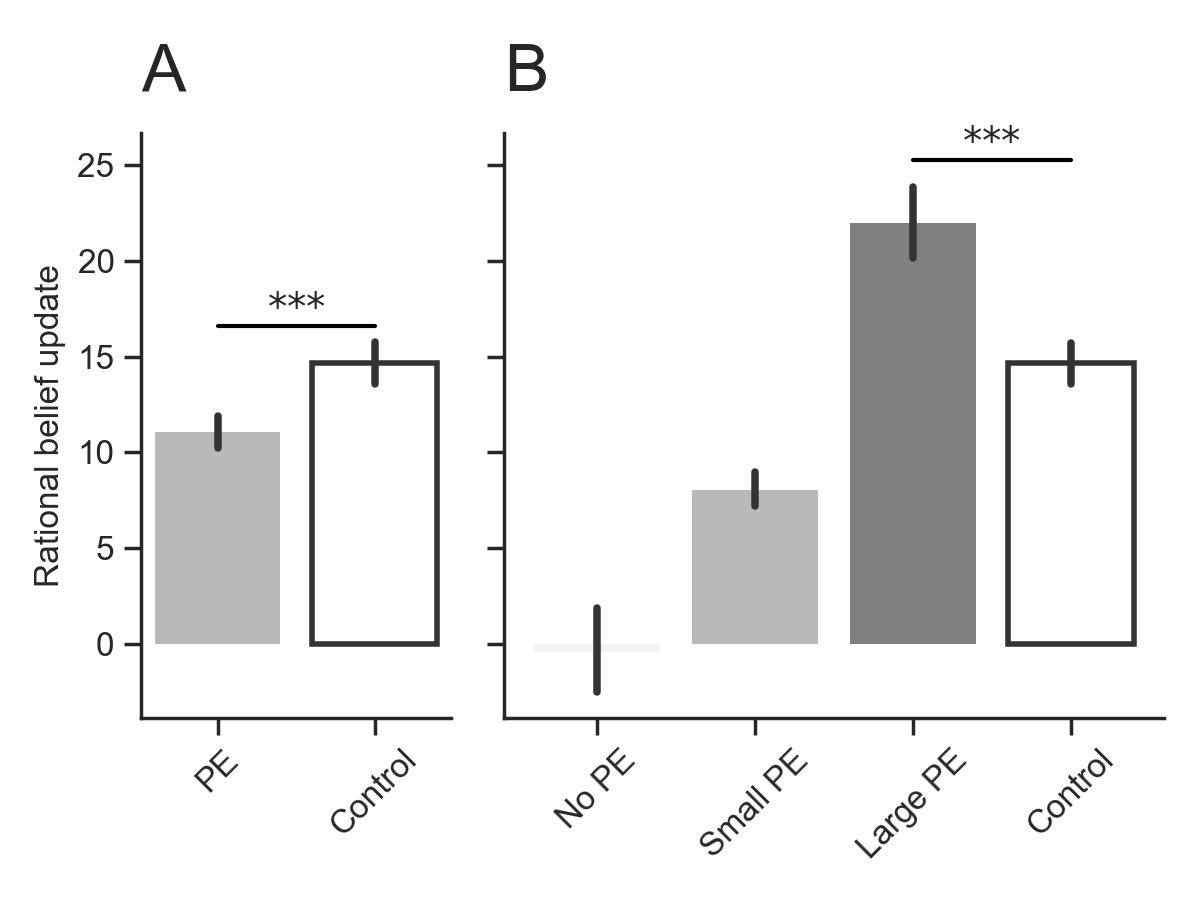

In [18]:
# Group and average data within participant and PE bin
AVDATA = DATA.groupby(["partnum"], as_index=False).mean()
# Plotting
fig, ax = plt.subplots(1,2, figsize=(6,4.5), gridspec_kw={"width_ratios": [1,2.125]}, sharey=True)
cust_palette = [sns.light_palette("gray", n_colors=len(bins))[1]] + [np.array([1, 1, 1, 0])]
sns.barplot(x="cond", y="RdeltaB", data=AVDATA, \
            palette=cust_palette, linewidth = [0,2], edgecolor=".2", errcolor=".2", \
            ax=ax[0]) 
sns.despine()
ax[0].set_xlabel("");
ax[0].set_xticklabels(["PE","Control"], rotation=45);
ax[0].set_ylabel("Rational belief update");
# Significance testing
datahandles = np.array([L.get_xydata() for L in ax[0].get_lines()])
_, p = stats.ttest_ind(AVDATA.loc[AVDATA["cond"]==1, "RdeltaB"], \
                       AVDATA.loc[AVDATA["cond"]==2, "RdeltaB"], equal_var=False)
bff.barplot_annotate_brackets(ax[0], 0, 1, p, datahandles, dh=0.05, fs=14)
plt.tight_layout()
bff.panellabel(ax[0], "A")



# Group and average data within participant and PE bin
AVDATA = DATA.groupby(["partnum", "binnedPE"], as_index=False).mean()
# Plotting
cust_palette = sns.light_palette("gray", n_colors=len(bins)) + [np.array([1, 1, 1, 0])]
sns.barplot(x="binnedPE", y="RdeltaB", data=AVDATA, \
            palette=cust_palette, linewidth = [0]*len(bins) + [2], edgecolor=".2", errcolor=".2", \
            ax=ax[1]) 
sns.despine()
ax[1].set_xlabel("");
ax[1].set_xticklabels(["No PE","Small PE","Large PE","Control"], rotation=45);
ax[1].set_ylabel("");
# Significance testing
datahandles = np.array([L.get_xydata() for L in ax[1].get_lines()])
_, p = stats.ttest_ind(AVDATA.loc[AVDATA["binnedPE"]==2, "RdeltaB"], \
                       AVDATA.loc[AVDATA["binnedPE"]==3, "RdeltaB"], equal_var=False)
bff.barplot_annotate_brackets(ax[1], 2, 3, p, datahandles, dh=0.05, fs=14)
plt.tight_layout()
bff.panellabel(ax[1], "B")

plt.savefig('fig.tif', dpi=300, format="tiff")

#### Main effect, split by participant $\times$ item ideology

<IPython.core.display.Javascript object>


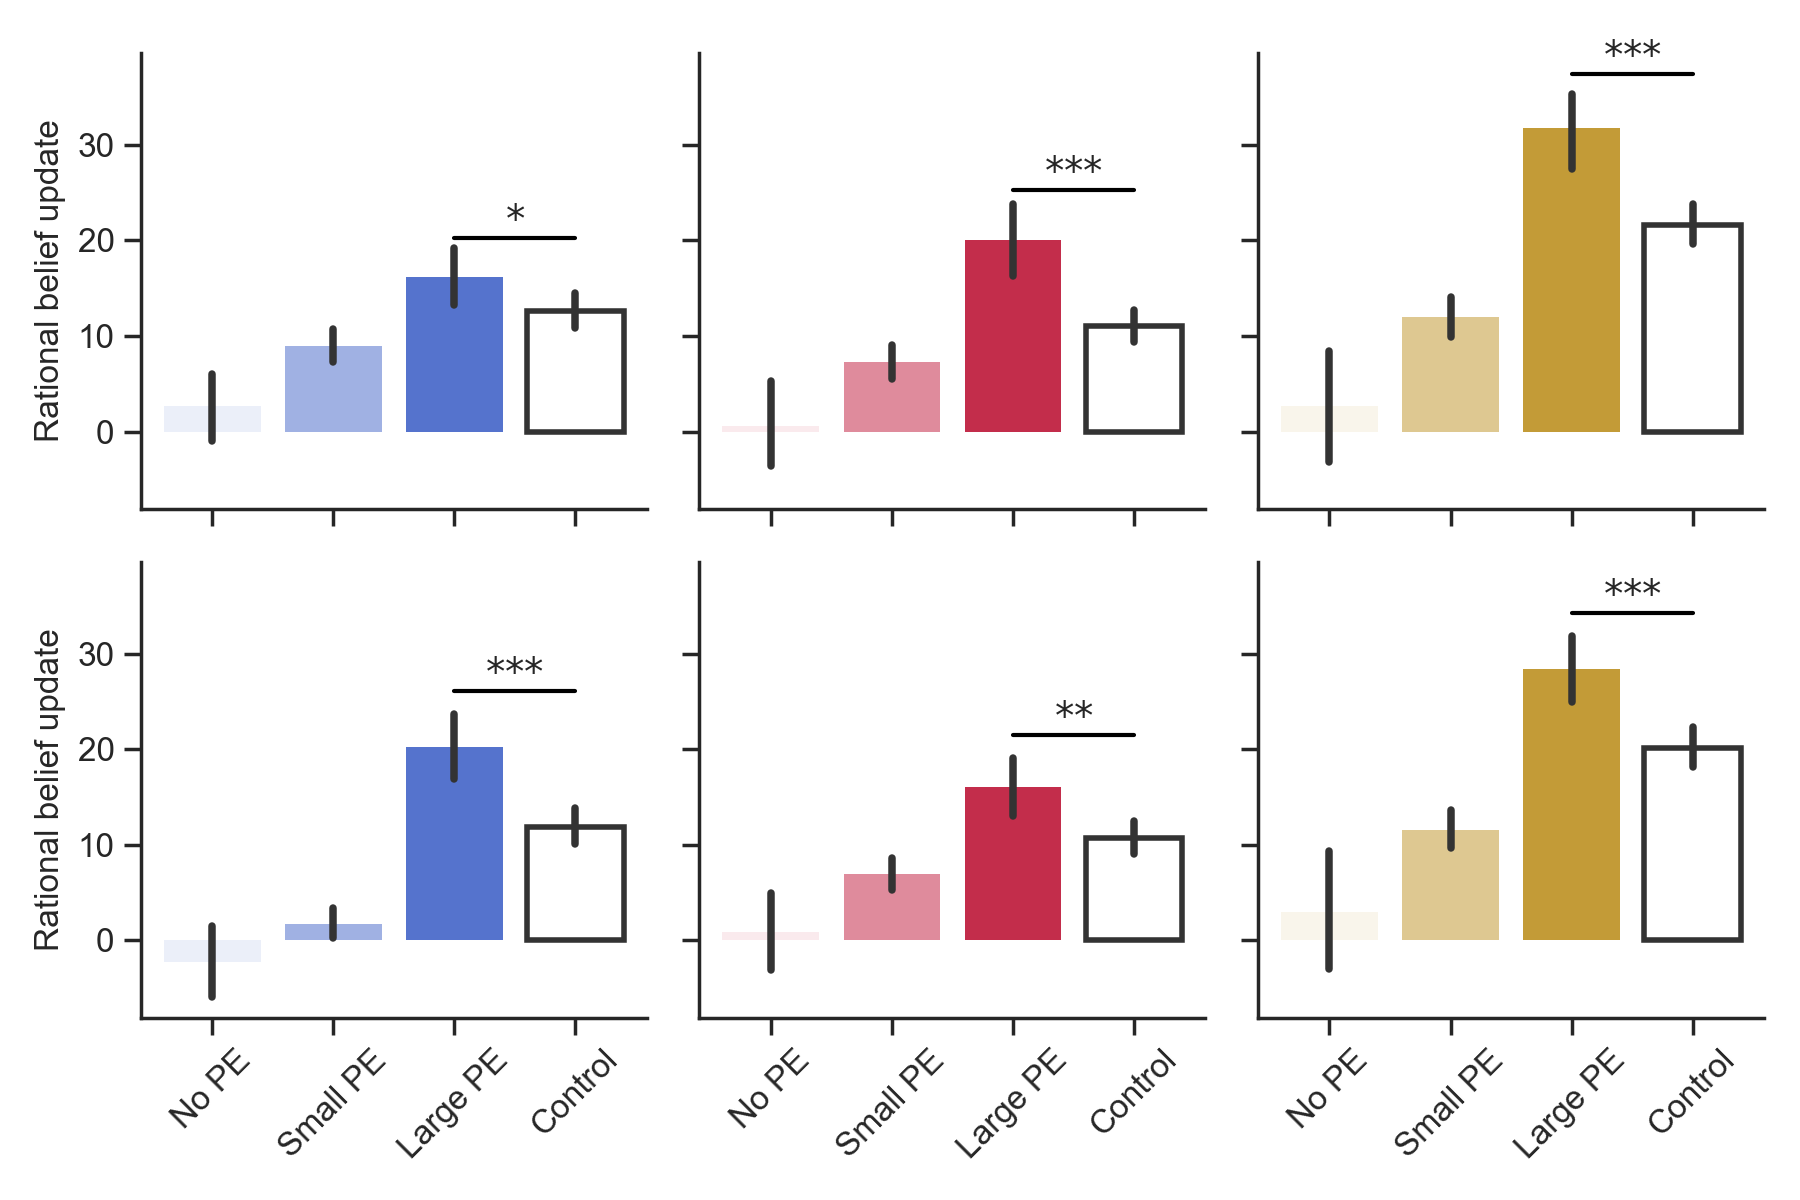

In [19]:
# Declare groups over which to split here:
grp1 = "partideology"
grp2 = "itemideology"

fig, ax = plt.subplots(len(DATA[grp1].unique()), len(DATA[grp2].unique()), figsize=(9,6), sharey=True)
colors = ["royalblue", "crimson", "goldenrod"]

# Split dataframe into groups, where grpDATA is a subsampled dataframe of DATA with one split's data at a time
svals = []
for name, grpDATA in DATA.groupby([grp1, grp2]):
    name = np.array(name, dtype=int) - 1
    cax = ax[name[0],name[1]]
    # Average the split's items within participants
    AVDATA = grpDATA.groupby(["partnum", "binnedPE"], as_index=False).mean()
    
    # Plotting
    cust_palette = sns.light_palette(colors[name[-1]], n_colors=len(bins)) + [np.array([1, 1, 1, 0])]
    sns.barplot(x="binnedPE", y="RdeltaB", data=AVDATA, \
                palette=cust_palette, linewidth = [0]*len(bins) + [2], edgecolor=".2", errcolor=".2", \
                ax=cax) 
    sns.despine()
    cax.set_xlabel("");
    if name[0] == len(DATA[grp1].unique())-1:
        cax.set_xticklabels(["No PE","Small PE","Large PE","Control"], rotation=45);
    else:
        cax.set_xticklabels("");
    if name[1] == 0:
        cax.set_ylabel("Rational belief update");
    else:
        cax.set_ylabel("");
    # Significance testing
    datahandles = np.array([L.get_xydata() for L in cax.get_lines()])
    res = ttest_ind(AVDATA.loc[AVDATA["binnedPE"]==2, "RdeltaB"], \
                    AVDATA.loc[AVDATA["binnedPE"]==3, "RdeltaB"])
    svals += [res]
    bff.barplot_annotate_brackets(cax, 2, 3, res[2], datahandles, dh=0.05, fs=14)

plt.tight_layout()
plt.savefig('fig.tif', dpi=300, format="tiff")

#### Line plots $-$
*PREDICTION CONDITION ONLY*

<IPython.core.display.Javascript object>


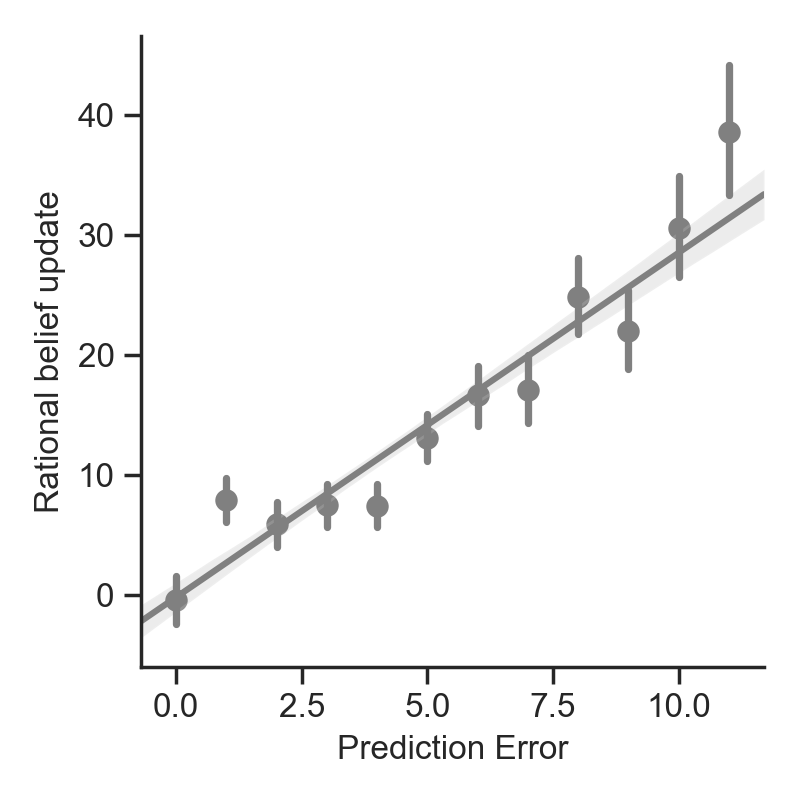

                            OLS Regression Results                            
Dep. Variable:                RdeltaB   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     589.0
Date:                Thu, 06 Feb 2020   Prob (F-statistic):          7.40e-121
Time:                        14:08:49   Log-Likelihood:                -16925.
No. Observations:                3701   AIC:                         3.385e+04
Df Residuals:                    3699   BIC:                         3.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1671      0.702     -0.238      0.8

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [20]:
# Group and average data within participant and PE bin
AVDATA = DATA.loc[DATA["cond"]==1,:].groupby(["partnum", "PE"], as_index=False).mean()

# Plotting
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.regplot(x="PE", y="RdeltaB", x_estimator=np.mean, data=AVDATA, \
            color="gray", ci=95, ax=ax)
sns.despine()
ax.set_xlabel("Prediction Error");
ax.set_ylabel("Rational belief update");

print(sm.OLS(AVDATA["RdeltaB"], sm.add_constant(AVDATA["PE"])).fit().summary())

plt.tight_layout()
plt.savefig('fig.tif', dpi=300, format="tiff")

## 4 $-$ Linear mixed effects model using ``statsmodels`` in Python



In [22]:
DATAexp = DATA[DATA["cond"]==1]
if "scaledPE" not in DATAexp:
    DATAexp.insert(4, "scaledPE", DATAexp[["PE"]].apply(stats.zscore))
map_dict = {1: "D", 2: "R", 3: "aN"}
if "pid" in DATAexp:
    DATAexp = DATAexp.drop("pid", axis=1)
    DATAexp = DATAexp.drop("iid", axis=1)
DATAexp.insert(12,"pid",DATAexp["partideology"].map(map_dict))
DATAexp.insert(10,"iid",DATAexp["itemideology"].map(map_dict))

DATAexp.head()

,RdeltaB,deltaB,signedPE,binnedPE,scaledPE,PE,Bpre,RpreI,overunder,supportagainst,iid,itemideology,itemnum,pid,cond,partideology,resist,partnum
0,13.0,-13.0,-1.0,1,-1.056046,1.0,80.0,80.0,1.0,1.0,aN,3.0,0.0,D,1.0,1.0,4.666667,0.0
1,-3.0,-3.0,4.0,1,-0.010234,4.0,84.0,16.0,1.0,1.0,aN,3.0,1.0,D,1.0,1.0,4.666667,0.0
2,11.0,11.0,1.0,1,-1.056046,1.0,70.0,30.0,1.0,1.0,aN,3.0,2.0,D,1.0,1.0,4.666667,0.0
3,-11.0,-11.0,-1.0,1,-1.056046,1.0,77.0,23.0,0.0,1.0,aN,3.0,3.0,D,1.0,1.0,4.666667,0.0
4,1.0,1.0,-7.0,2,1.035578,7.0,71.0,29.0,0.0,1.0,aN,3.0,4.0,D,1.0,1.0,4.666667,0.0


In [25]:
import warnings
warnings.filterwarnings('ignore')

%load_ext rpy2.ipython
# %R library(lme4)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [26]:
%R library(lmerTest)

array(['lmerTest', 'lme4', 'Matrix', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

- Push data to the R side (``FutureWarning: from_items is deprecated`` is normal)

In [27]:
%Rpush DATAexp

- Run the linear mixed model fit in full R syntax

In [28]:
%%R

M <- lmer(RdeltaB ~ PE:iid:pid + (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

rfs <- ranef(M)$partnum
ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ PE:iid:pid + (1 | partnum) + (1 | itemnum)
   Data: DATAexp

REML criterion at convergence: 123312.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2899 -0.5481 -0.0223  0.5905  3.5987 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  43.74    6.613  
 itemnum  (Intercept) 111.73   10.570  
 Residual             949.17   30.809  
Number of obs: 12672, groups:  partnum, 352; itemnum, 36

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)      2.1888     1.8701   41.6985   1.170    0.248    
PE:iidaN:pidD    2.3528     0.2198 8435.3785  10.704   <2e-16 ***
PE:iidD:pidD     2.4808     0.2121 9513.1788  11.696   <2e-16 ***
PE:iidR:pidD     2.1517     0.2103 9888.8750  10.230   <2e-16 ***
PE:iidaN:pidR    2.2656     0.2163 8398.0088  10.474   <2e-16 ***
PE:iidD:pidR     1.9654     0.2089 9351.5838  

In [29]:
%%R

M <- lmer(RdeltaB ~ scaledRpreI + PE (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

rfs <- ranef(M)$partnum
ffs <- fixef(M)


Error in eval(predvars, data, env) : object 'scaledRpreI' not found


- Pull data back to the Python side

In [30]:
%Rpull rfs
%Rpull ffs

- Unpack the R object into a list 

#### Perform the full LMM

In [31]:
%Rpush DATAexp

In [32]:
%%R

M <- lmer(RdeltaB ~ PE*pid*iid + (1 | partnum) + (1 | itemnum), data = DATAexp)
# M <- lmer(RdeltaB ~ PE + pid + PE:pid + PE:iid + PE:pid:iid + (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

rfs_part <- ranef(M)$partnum
rfs_item <- ranef(M)$itemnum
ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ PE * pid * iid + (1 | partnum) + (1 | itemnum)
   Data: DATAexp

REML criterion at convergence: 123272.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3500 -0.5481 -0.0235  0.5906  3.5881 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  43.79    6.618  
 itemnum  (Intercept) 108.76   10.429  
 Residual             947.99   30.790  
Number of obs: 12672, groups:  partnum, 352; itemnum, 36

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   5.653e+00  3.294e+00  4.492e+01   1.716 0.093034 .  
PE            2.462e+00  2.569e-01  1.253e+04   9.584  < 2e-16 ***
pidR          1.614e+00  1.802e+00  4.416e+03   0.896 0.370241    
iidD         -3.286e+00  4.594e+00  4.252e+01  -0.715 0.478437    
iidR         -4.892e+00  4.590e+00  4.236e+01  -1.066 0.292546    
PE:pidR      -4.351e-01  3.310e-01  

In [33]:
%Rpull rfs_part
%Rpull rfs_item
%Rpull ffs

In [44]:
# Fixed effects can be used to show linear predictions under the mixed model
fixedeffects = [ffs[i] for i in range(len(ffs))]
# Random effects can be used to show linear data with the random effects already removed
randomeffects = [[rfs_part[0][i] for i in range(len(rfs_part[0]))], [rfs_item[0][i] for i in range(len(rfs_item[0]))]]
rm_re = np.array([randomeffects[0][i] + randomeffects[1][j] for i in range(len(randomeffects[0])) for j in range(len(randomeffects[1]))])
if "RdeltaB_corrected" in DATAexp:
    DATAexp = DATAexp.drop("RdeltaB_corrected", axis=1)
DATAexp.insert(1,"RdeltaB_corrected",DATAexp["RdeltaB"] - rm_re)
DATAexp.head()

,RdeltaB,RdeltaB_corrected,deltaB,signedPE,binnedPE,scaledPE,PE,scaledRpreI,Bpre,RpreI,iid,overunder,supportagainst,pid,itemideology,itemnum,cond,partideology,resist,partnum
0,13.0,23.282025,-13.0,-1.0,1,-1.056046,1.0,0.819935,80.0,80.0,aN,1.0,1.0,D,3.0,0.0,1.0,1.0,4.666667,0.0
1,-3.0,6.364847,-3.0,4.0,1,-0.010234,4.0,-1.332432,84.0,16.0,aN,1.0,1.0,D,3.0,1.0,1.0,1.0,4.666667,0.0
2,11.0,34.382497,11.0,1.0,1,-1.056046,1.0,-0.861602,70.0,30.0,aN,1.0,1.0,D,3.0,2.0,1.0,1.0,4.666667,0.0
3,-11.0,4.339496,-11.0,-1.0,1,-1.056046,1.0,-1.097017,77.0,23.0,aN,0.0,1.0,D,3.0,3.0,1.0,1.0,4.666667,0.0
4,1.0,13.763751,1.0,-7.0,2,1.035578,7.0,-0.895233,71.0,29.0,aN,0.0,1.0,D,3.0,4.0,1.0,1.0,4.666667,0.0


<IPython.core.display.Javascript object>


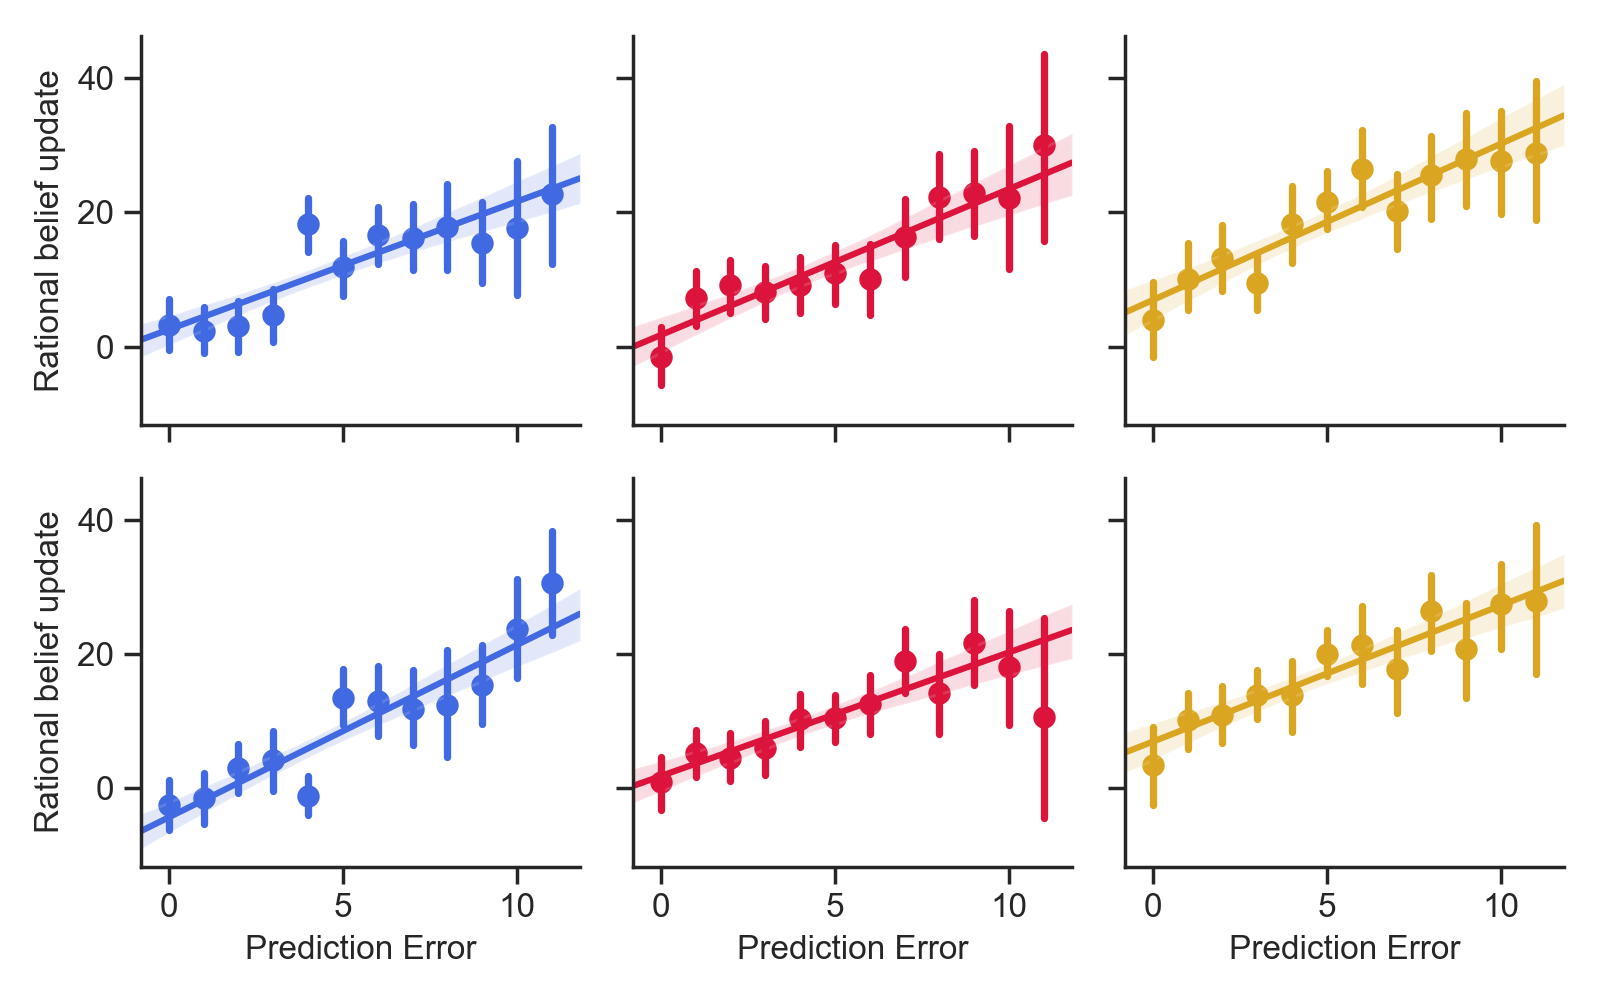

In [36]:
# Declare groups over which to split here:
grp1 = "partideology"
grp2 = "itemideology"

fig, ax = plt.subplots(len(DATA[grp1].unique()), len(DATA[grp2].unique()), figsize=(8,5), sharey=True)
colors = ["royalblue", "crimson", "goldenrod"]

# Split dataframe into groups, where grpDATA is a subsampled dataframe of DATA with one split's data at a time
for name, grpDATA in DATAexp.groupby([grp1, grp2]):
    name = np.array(name, dtype=int) - 1
    cax = ax[name[0],name[1]]
    # Average the split's items within participants
    AVDATA = grpDATA.groupby(["partnum", "PE"], as_index=False).mean()
    
    # Plotting  x_estimator=np.mean
#     sns.regplot(x="PE", y="RdeltaB", scatter=True, data=AVDATA, \
#                 color=colors[name[-1]], ci=99, x_jitter=.1, marker=".", scatter_kws={'s':2}, \
#                 ax=cax)
    sns.regplot(x="PE", y="RdeltaB_corrected", x_estimator=np.mean, data=AVDATA, \
                color=colors[name[-1]], ci=95, ax=cax)
    sns.despine()
    if name[0] == len(DATA[grp1].unique())-1:
        cax.set_xlabel("Prediction Error");
    else:
        cax.set_xticklabels("");
        cax.set_xlabel("");
    if name[1] == 0:
        cax.set_ylabel("Rational belief update");
    else:
        cax.set_ylabel("");
    
plt.tight_layout()
plt.savefig('fig.tif', dpi=300, format="tiff")

## 5.1 $-$ Extended LMER with belief @ PRE
Adding belief @ PRE as an additional random effect to make sure it's not a trivial explanatory factor.


In [49]:
if "scaledRpreI" not in DATAexp:
    DATAexp.insert(7, "scaledRpreI", DATAexp[["RpreI"]].apply(stats.zscore))
map_dict = {1: "D", 2: "R", 3: "aN"}
if "pid" in DATAexp:
    DATAexp = DATAexp.drop("pid", axis=1)
    DATAexp = DATAexp.drop("iid", axis=1)
DATAexp.insert(12,"pid",DATAexp["partideology"].map(map_dict))
DATAexp.insert(10,"iid",DATAexp["itemideology"].map(map_dict))

DATAexp.head()

,RdeltaB,RdeltaB_corrected,deltaB,signedPE,binnedPE,scaledPE,PE,scaledRpreI,Bpre,RpreI,iid,overunder,supportagainst,pid,itemideology,itemnum,cond,partideology,resist,partnum
0,13.0,21.263067,-13.0,-1.0,1,-1.056046,1.0,0.819935,80.0,80.0,aN,1.0,1.0,D,3.0,0.0,1.0,1.0,4.666667,0.0
1,-3.0,9.645747,-3.0,4.0,1,-0.010234,4.0,-1.332432,84.0,16.0,aN,1.0,1.0,D,3.0,1.0,1.0,1.0,4.666667,0.0
2,11.0,36.504053,11.0,1.0,1,-1.056046,1.0,-0.861602,70.0,30.0,aN,1.0,1.0,D,3.0,2.0,1.0,1.0,4.666667,0.0
3,-11.0,7.040724,-11.0,-1.0,1,-1.056046,1.0,-1.097017,77.0,23.0,aN,0.0,1.0,D,3.0,3.0,1.0,1.0,4.666667,0.0
4,1.0,15.968118,1.0,-7.0,2,1.035578,7.0,-0.895233,71.0,29.0,aN,0.0,1.0,D,3.0,4.0,1.0,1.0,4.666667,0.0


In [50]:
%Rpush DATAexp

In [51]:
%%R

M <- lmer(RdeltaB ~ scaledRpreI + PE + (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

rfs <- ranef(M)$partnum
ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ scaledRpreI + PE + (1 | partnum) + (1 | itemnum)
   Data: DATAexp

REML criterion at convergence: 119593.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4638 -0.7168  0.0814  0.7249  2.9431 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  37.17    6.097  
 itemnum  (Intercept)  66.60    8.161  
 Residual             706.55   26.581  
Number of obs: 12672, groups:  partnum, 352; itemnum, 36

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 4.688e+00  1.469e+00 4.470e+01   3.192  0.00259 ** 
scaledRpreI 1.680e+01  2.554e-01 1.253e+04  65.780  < 2e-16 ***
PE          1.580e+00  9.472e-02 1.249e+04  16.684  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) scldRI
scaledRpreI  0.026       
PE          -0.260 -0.100


In [52]:
%%R

M <- lmer(RdeltaB ~ scaledRpreI + PE:iid:pid + (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

rfs <- ranef(M)$partnum
ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ scaledRpreI + PE:iid:pid + (1 | partnum) + (1 | itemnum)
   Data: DATAexp

REML criterion at convergence: 119571.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4695 -0.7237  0.0813  0.7269  2.9691 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  36.90    6.075  
 itemnum  (Intercept)  61.18    7.822  
 Residual             705.44   26.560  
Number of obs: 12672, groups:  partnum, 352; itemnum, 36

Fixed effects:
               Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   4.599e+00  1.416e+00 4.524e+01   3.247   0.0022 ** 
scaledRpreI   1.686e+01  2.554e-01 1.251e+04  66.002  < 2e-16 ***
PE:iidaN:pidD 2.122e+00  1.888e-01 6.904e+03  11.242  < 2e-16 ***
PE:iidD:pidD  1.802e+00  1.826e-01 8.156e+03   9.866  < 2e-16 ***
PE:iidR:pidD  1.294e+00  1.814e-01 8.693e+03   7.134 1.05e-12 ***
PE:iidaN:pidR 2.001e+00  1.858e-

In [53]:
%%R

M <- lmer(RdeltaB ~ scaledRpreI + PE*pid*iid + (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

rfs_part <- ranef(M)$partnum
rfs_item <- ranef(M)$itemnum
ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ scaledRpreI + PE * pid * iid + (1 | partnum) + (1 |  
    itemnum)
   Data: DATAexp

REML criterion at convergence: 119551

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4845 -0.7199  0.0838  0.7243  2.9859 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  36.98    6.081  
 itemnum  (Intercept)  62.40    7.899  
 Residual             705.42   26.560  
Number of obs: 12672, groups:  partnum, 352; itemnum, 36

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   5.826e+00  2.560e+00  4.901e+01   2.276  0.02727 *  
scaledRpreI   1.684e+01  2.559e-01  1.251e+04  65.808  < 2e-16 ***
PE            2.206e+00  2.216e-01  1.246e+04   9.954  < 2e-16 ***
pidR          1.256e+00  1.570e+00  4.059e+03   0.800  0.42404    
iidD         -2.175e+00  3.552e+00  4.544e+01  -0.612  0.54338    
iidR         -5.98

In [54]:
%Rpull rfs_part
%Rpull rfs_item
%Rpull ffs

In [55]:
# Fixed effects can be used to show linear predictions under the mixed model
#    NOTE: Skip ffs[1] in the model that includes "RpreI"
fixedeffects = [ffs[0]] + [ffs[i] for i in range(2,len(ffs))]

# Random effects can be used to show linear data with the random effects already removed
randomeffects = [[rfs_part[0][i] for i in range(len(rfs_part[0]))], [rfs_item[0][i] for i in range(len(rfs_item[0]))]]
rm_re = np.array([randomeffects[0][i] + randomeffects[1][j] for i in range(len(randomeffects[0])) for j in range(len(randomeffects[1]))])
# Append the predictions under "RpreI"
rm_re += ffs[1]*DATAexp["scaledRpreI"]

# Add the correction term to the data table
if "RdeltaB_corrected" in DATAexp:
    DATAexp = DATAexp.drop("RdeltaB_corrected", axis=1)
DATAexp.insert(1,"RdeltaB_corrected",DATAexp["RdeltaB"] - rm_re)
DATAexp.head()

,RdeltaB,RdeltaB_corrected,deltaB,signedPE,binnedPE,scaledPE,PE,scaledRpreI,Bpre,RpreI,iid,overunder,supportagainst,pid,itemideology,itemnum,cond,partideology,resist,partnum
0,13.0,5.500938,-13.0,-1.0,1,-1.056046,1.0,0.819935,80.0,80.0,aN,1.0,1.0,D,3.0,0.0,1.0,1.0,4.666667,0.0
1,-3.0,21.860140,-3.0,4.0,1,-0.010234,4.0,-1.332432,84.0,16.0,aN,1.0,1.0,D,3.0,1.0,1.0,1.0,4.666667,0.0
2,11.0,45.803180,11.0,1.0,1,-1.056046,1.0,-0.861602,70.0,30.0,aN,1.0,1.0,D,3.0,2.0,1.0,1.0,4.666667,0.0
3,-11.0,26.758884,-11.0,-1.0,1,-1.056046,1.0,-1.097017,77.0,23.0,aN,0.0,1.0,D,3.0,3.0,1.0,1.0,4.666667,0.0
4,1.0,21.694676,1.0,-7.0,2,1.035578,7.0,-0.895233,71.0,29.0,aN,0.0,1.0,D,3.0,4.0,1.0,1.0,4.666667,0.0


---

<IPython.core.display.Javascript object>


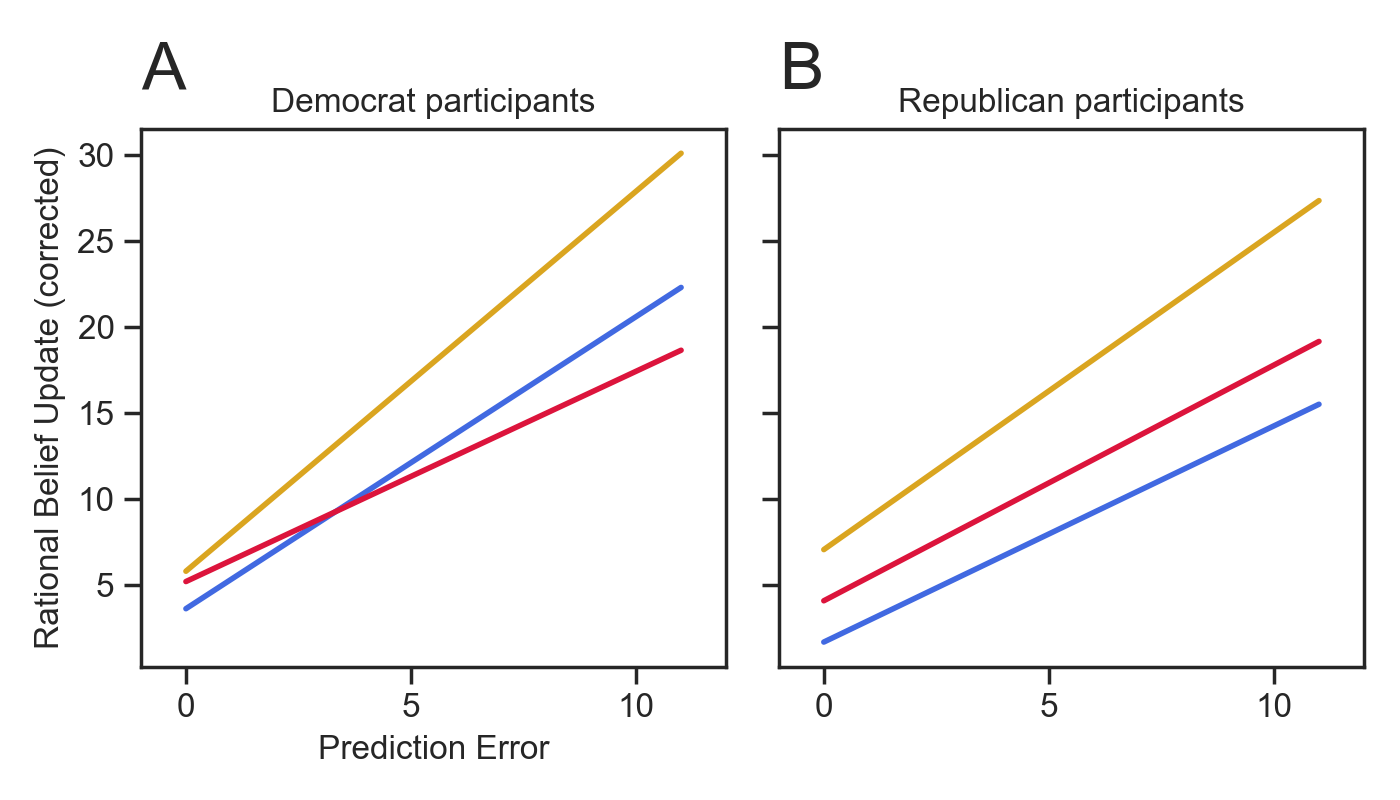

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(7,4), sharey=True)
colors = ["royalblue", "crimson", "goldenrod"]
        
# RECONSTRUCT THE MIXED MODEL FITS FROM ``fixedeffects``
c = fixedeffects
def lines(x, s):
    SS = {
          "DI": [1, x, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], \
          "DD": [1, x, 0, 1, 0, 0, x, 0, 0, 0, 0, 0], \
          "DR": [1, x, 0, 0, 1, 0, 0, x, 0, 0, 0, 0], \
          "RI": [1, x, 1, 0, 0, x, 0, 0, 0, 0, 0, 0], \
          "RD": [1, x, 1, 1, 0, x, x, 0, 1, 0, x, 0], \
          "RR": [1, x, 1, 0, 1, x, 0, x, 0, 1, 0, x]
         }
    return c @ np.array(SS[s])
L = [0, 11] # list(ax[0].get_xlim()); L[0] = 0
ax[0].plot(L, [lines(L[0], "DI"), lines(L[1], "DI")], lw=2, c=colors[-1])
ax[0].plot(L, [lines(L[0], "DD"), lines(L[1], "DD")], lw=2, c=colors[0])
ax[0].plot(L, [lines(L[0], "DR"), lines(L[1], "DR")], lw=2, c=colors[1])
ax[0].set_xlim([-1, 12])
ax[0].set_xlabel("Prediction Error")
ax[0].set_ylabel("Rational Belief Update (corrected)")
ax[0].set_title("Democrat participants")
bff.panellabel(ax[0], "A")
L = [0, 11] # list(ax[1].get_xlim()); L[0] = 0
ax[1].plot(L, [lines(L[0], "RI"), lines(L[1], "RI")], lw=2, c=colors[-1])
ax[1].plot(L, [lines(L[0], "RD"), lines(L[1], "RD")], lw=2, c=colors[0])
ax[1].plot(L, [lines(L[0], "RR"), lines(L[1], "RR")], lw=2, c=colors[1])
ax[1].set_xlim([-1, 12])
ax[1].set_title("Republican participants")

bff.panellabel(ax[1], "B")

plt.tight_layout()
plt.savefig('fig4.tif', dpi=300, format="tiff")

## 6 $-$ Moderation model


In [57]:
%%R

M <- lmer(RdeltaB ~ scaledRpreI + PE*resist + (1 | partnum) + (1 | itemnum), data = DATAexp)
print(summary(M))

# rfs_part <- ranef(M)$partnum
# rfs_item <- ranef(M)$itemnum
# ffs <- fixef(M)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ scaledRpreI + PE * resist + (1 | partnum) + (1 | itemnum)
   Data: DATAexp

REML criterion at convergence: 119573.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4620 -0.7150  0.0809  0.7241  2.9593 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  34.58    5.88   
 itemnum  (Intercept)  66.74    8.17   
 Residual             706.31   26.58   
Number of obs: 12672, groups:  partnum, 352; itemnum, 36

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     8.8103     2.6453   375.2941   3.331 0.000953 ***
scaledRpreI    16.7810     0.2553 12530.1972  65.727  < 2e-16 ***
PE              2.3461     0.3691 12557.2133   6.356 2.14e-10 ***
resist         -1.2173     0.6487  1018.2669  -1.877 0.060862 .  
PE:resist      -0.2212     0.1043 12550.5764  -2.122 0.033850 *  
---
Signif. codes:  0 ‘***’ 0.0